# old 方法: YOLOv4

In [1]:
import sys
sys.path.append("..")

import pandas as pd
from models import Yolov4
from tensorflow import keras
from config import yolo_config
from iou import get_iou, calculate_ciou
from utils import DataGenerator, read_annotation_lines

import numpy as np
from glob import glob
from tqdm.notebook import tqdm

import seaborn as sns
from turtle import color
from matplotlib import style
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import math
import cv2 as cv
import xml.etree.ElementTree as ET

import os
# 使用第二張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 載入模型

In [2]:
# yolo_config['score_threshold']=0.7
# print(yolo_config)

In [3]:
import warnings
warnings.filterwarnings('ignore')
class_name_path = '../class_names/classes.txt'
model = Yolov4(
               weight_path    = None, 
               config         = yolo_config,
               class_name_path= class_name_path, 
               )
model.load_weights(path="../model/202301/20230103_nosmooth.weights")

2023-01-11 19:35:30.396861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 19:35:30.402229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 19:35:30.402658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 19:35:30.403535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

nms iou: 0.0 score: 0.0


# 使用 stage1 分類預測結果的 "真值"

In [4]:
# stage1_pred_result = pd.read_pickle("../../classification/result/stage1_pred_result_train.pickle")   # 這邊換stage1結果!!!!!!!!!!!!!!!!!!!!!!!!!!!!
stage1_pred_result = pd.read_pickle("../../classification/result/stage1_pred_result_test.pickle")   # 這邊換stage1結果!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# stage1_pred_result = pd.read_pickle("../../classification/result/stage1_pred_result_validation.pickle")   # 這邊換stage1結果!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# stage1_pred_result = pd.read_pickle("../../classification/result/stage1_pred_result_test_nosmooth.pickle")   # 這邊換stage1結果!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [5]:
stage1_pred_result = stage1_pred_result.drop(columns=['stage1_test_pred'])
stage1_pred_result

,test_name,test_true
0,h_000002.png,0
1,h_000003.png,0
2,h_000004.png,0
3,h_000005.png,0
4,h_000006.png,0
...,...,...
365,z_000077.png,1
366,z_000078.png,1
367,z_000079.png,1
368,z_000080.png,1


# 每一個test image "True" bounding box

In [6]:
true_box_PATH = '../test_dataset/txt/20221102_anno_test_lines_0.txt'       # 這邊要修改train/test 的路徑!!!!!!!!
# true_box_PATH = '../dataset/txt/20221102_anno_train_lines_0.txt'
# true_box_PATH = '../dataset/txt/20221102_anno_val_lines_0.txt'


true_bboxes_names = []
true_bboxes_list  = []
with open(true_box_PATH) as f:
    for line in f.readlines():
        true_bboxes_list.append(tuple([int(i) for i in line.split(' ')[1].split(',')[:4]]))
        true_bboxes_names.append(line.split(' ')[0])
        

In [7]:
true_bboxes = pd.DataFrame({'test_name':true_bboxes_names, 
                            'true_bbox':true_bboxes_list
                          })
true_bboxes

,test_name,true_bbox
0,h_000048.png,"(432, 24, 659, 281)"
1,h_000049.png,"(273, 19, 529, 297)"
2,h_000050.png,"(202, 99, 442, 358)"
3,h_000051.png,"(139, 288, 367, 573)"
4,h_000053.png,"(113, 259, 359, 560)"
...,...,...
184,z_000077.png,"(169, 6, 636, 604)"
185,z_000078.png,"(205, 34, 685, 611)"
186,z_000079.png,"(202, 30, 687, 606)"
187,z_000080.png,"(189, 35, 680, 618)"


In [8]:
result_table = stage1_pred_result.merge(true_bboxes, on=['test_name'], how='left')
result_table = result_table.fillna('NO')
result_table

,test_name,test_true,true_bbox
0,h_000002.png,0,NO
1,h_000003.png,0,NO
2,h_000004.png,0,NO
3,h_000005.png,0,NO
4,h_000006.png,0,NO
...,...,...,...
365,z_000077.png,1,"(169, 6, 636, 604)"
366,z_000078.png,1,"(205, 34, 685, 611)"
367,z_000079.png,1,"(202, 30, 687, 606)"
368,z_000080.png,1,"(189, 35, 680, 618)"


# 每一個test image "Pred" bounding box

In [9]:
train = ['a', 'b', 'c', 'e', 'f', 'g', 'j', 'm', 'n', 'p', 'r', 's', 't', 'u']
val   = ['d', 'i', 'k', 'o']
test  = ['h', 'l', 'q', 'z'] 

PATH = '../../classification/dataset_22video_20221031/test/0/'
# PATH = '../../classification/dataset_smooth_22video_20221031/test/0/'
# PATH = '../../classification/dataset_smooth_22video_20221031/test/0/'
# PATH = '../dataset/img/20221024_train_vali_img_sopbox_0/'                        # 這邊要修改train/test 的路徑!!!!!!!!

pred_bboxes_names  = []  # all image names
pred_bboxes_scores = []  # all bboxes scores
pred_bboxes_list   = []  # all bboxes
for test_img_name in result_table[result_table['test_true']==0]['test_name']:  # glob(os.path.join(PATH, '*.png')):
    test_img_path = PATH + test_img_name
    output_img, detections = model.predict(img_path=test_img_path, 
                                            random_color=False, # 框顏色
                                            plot_img=False, # 顯示出框選圖片
                                            show_text=True, # 框上面加上類別文字
                                            box_num=1,      # 顯示框的數量
                                            return_output=True)
    
    limit = 1 #len(detections['score'])                            # 這邊要修改無限制 / 限制數量1個  !!!!!!!!!!!
    pred_box_num = len(detections['score'])  
    print("pred_box_num= ",pred_box_num)                    
    if pred_box_num > 0:       # 有預測出box
        for i in range(limit):
            score = detections[i:i+1]['score'].to_numpy()[0]
            print("score = ",score)
            if score >= 0.1:                                        # 這邊放寬score限制，看混淆矩陣狀況 !!!!!!!!!!! 
                pred_bboxes_names.append(test_img_name)
                pred_bboxes_scores.append(score)
                pred_bboxes_list.append(tuple(detections[i:i+1][['x1','y1','x2','y2']].to_numpy()[0]))

            else:
                pred_bboxes_names.append(test_img_name)
                pred_bboxes_scores.append(score)
                pred_bboxes_list.append('NO')
    else:
        pred_bboxes_names.append(test_img_name)
        pred_bboxes_scores.append(0.0)
        pred_bboxes_list.append('NO')
        print('沒有預測出來有box(label)')

PATH = '../../classification/dataset_22video_20221031/test/1/'  #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!  要記得換
# PATH = '../../classification/dataset_smooth_22video_20221031/test/1/'
for test_img_name in result_table[result_table['test_true']==1]['test_name']:  # glob(os.path.join(PATH, '*.png')):
    test_img_path = PATH + test_img_name
    output_img, detections = model.predict(img_path=test_img_path, 
                                            random_color=False, # 框顏色
                                            plot_img=False, # 顯示出框選圖片
                                            show_text=True, # 框上面加上類別文字
                                            box_num=1,      # 顯示框的數量
                                            return_output=True)
    
    limit = 1 #len(detections['score'])                            # 這邊要修改無限制 / 限制數量1個  !!!!!!!!!!!
    pred_box_num = len(detections['score'])  
    print("pred_box_num= ",pred_box_num)                    
    if pred_box_num > 0:       # 有預測出box
        for i in range(limit):
            score = detections[i:i+1]['score'].to_numpy()[0]
            print("score = ",score)
            if score >= 0.1:                                        # 這邊放寬score限制，看混淆矩陣狀況 !!!!!!!!!!! 
                pred_bboxes_names.append(test_img_name)
                pred_bboxes_scores.append(score)
                pred_bboxes_list.append(tuple(detections[i:i+1][['x1','y1','x2','y2']].to_numpy()[0]))

            else:
                pred_bboxes_names.append(test_img_name)
                pred_bboxes_scores.append(score)
                pred_bboxes_list.append('NO')
    else:
        pred_bboxes_names.append(test_img_name)
        pred_bboxes_scores.append(0.0)
        pred_bboxes_list.append('NO')
        print('沒有預測出來有box(label)')

2023-01-11 19:35:36.119244: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


1/1 [==============================] - 2s 2s/step
# of bboxes: 1
pred_box_num=  1
score =  0.38726214
1/1 [==============================] - 0s 34ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.43329492
1/1 [==============================] - 0s 33ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.5487853
1/1 [==============================] - 0s 33ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.5430704
1/1 [==============================] - 0s 33ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.4404096
1/1 [==============================] - 0s 33ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.57704276
1/1 [==============================] - 0s 33ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.41026637
1/1 [==============================] - 0s 33ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.52459824
1/1 [==============================] - 0s 33ms/step
# of bboxes: 1
pred_box_num=  1
score =  0.36465672
1/1 [==============================] - 0s 32ms/step
# of bboxes: 1
pr

In [10]:
pred_bboxes = pd.DataFrame({'test_name':pred_bboxes_names, 
                            'pred_bbox':pred_bboxes_list,
                            'score':pred_bboxes_scores
               })
pred_bboxes

,test_name,pred_bbox,score
0,h_000002.png,"(226, 136, 636, 737)",0.387262
1,h_000003.png,"(230, 146, 626, 729)",0.433295
2,h_000004.png,"(332, 42, 760, 604)",0.548785
3,h_000005.png,"(146, 116, 488, 637)",0.543070
4,h_000006.png,"(177, 102, 563, 651)",0.440410
...,...,...,...
365,z_000077.png,"(153, 0, 596, 537)",0.639760
366,z_000078.png,"(207, 0, 654, 543)",0.621099
367,z_000079.png,"(163, 0, 591, 537)",0.633821
368,z_000080.png,"(158, 49, 599, 587)",0.663093


# Left join table

In [11]:
result_table          = result_table.merge(pred_bboxes, on=['test_name'], how='left')
result_table['score'] = result_table['score'].fillna(0)  # 分數補0
result_table          = result_table.fillna('NO')       # bbox補'NO'
result_table

,test_name,test_true,true_bbox,pred_bbox,score
0,h_000002.png,0,NO,"(226, 136, 636, 737)",0.387262
1,h_000003.png,0,NO,"(230, 146, 626, 729)",0.433295
2,h_000004.png,0,NO,"(332, 42, 760, 604)",0.548785
3,h_000005.png,0,NO,"(146, 116, 488, 637)",0.543070
4,h_000006.png,0,NO,"(177, 102, 563, 651)",0.440410
...,...,...,...,...,...
365,z_000077.png,1,"(169, 6, 636, 604)","(153, 0, 596, 537)",0.639760
366,z_000078.png,1,"(205, 34, 685, 611)","(207, 0, 654, 543)",0.621099
367,z_000079.png,1,"(202, 30, 687, 606)","(163, 0, 591, 537)",0.633821
368,z_000080.png,1,"(189, 35, 680, 618)","(158, 49, 599, 587)",0.663093


# 計算iou
參數:

iou_threshold = 0.7    "iou大於0.7才是有框選到"

In [12]:
def valid(TP, FN, FP, TN):
    
    precision = 0 if (TP+FP)==0 else TP/(TP+FP)
    recall    = 0 if (TP+FN)==0 else TP/(TP+FN)
    f1        = 0 if (precision+recall)==0 else 2*precision*recall/(precision+recall)

    print('precision={:.2f}, recall={:.2f}, f1={:.2f}'.format(precision, recall, f1))
    print(TP,"|",FN,"\n",
          FP,"|",TN)

    return precision, recall, f1

In [13]:
def plt_precision_recall_curve_1(y_true, y_scores):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    average_precision             = average_precision_score(y_true, y_scores)
    # 用套件畫
    # disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision)
    # disp.plot()
    # plt.ylim([0.0, 1.05])
    # plt.xlim([0.0, 1.0])
    # plt.show()

    # 自己畫
    plt.plot(recall, precision, 'b-')   
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])  
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('precision_recall_curve')
    plt.legend(['AP={}'.format(round(average_precision,2))])
    plt.show()

    # print('precision = ', precision)
    # print('recall = ', recall)
    # print('thresholds = ',thresholds)
    print('AP={:.2f}'.format(average_precision))

In [14]:
def plt_heatmap(con_ma):
    '''
    :input: con_ma:[[TP,FN],[FP,TN]]
    '''
    sns.set(font_scale=1.5)
    f,ax=plt.subplots()
    sns.heatmap(con_ma, annot=True, ax=ax, fmt='d', cmap='YlGnBu', vmax=200, vmin=0) # 畫熱力圖
    ax.set_title('confusion matrix') # 標題
    ax.set_xlabel('predict')         # x軸
    ax.set_ylabel('true')            # y軸
    ax.xaxis.set_ticklabels(['Papilla', 'No Papilla'])
    ax.yaxis.set_ticklabels(['Papilla', 'No Papilla'])
    plt.show()

# old測試集結果 ciou_threshold=0.5:0.05:0.95

In [15]:
row, column = result_table.shape
result_table

,test_name,test_true,true_bbox,pred_bbox,score
0,h_000002.png,0,NO,"(226, 136, 636, 737)",0.387262
1,h_000003.png,0,NO,"(230, 146, 626, 729)",0.433295
2,h_000004.png,0,NO,"(332, 42, 760, 604)",0.548785
3,h_000005.png,0,NO,"(146, 116, 488, 637)",0.543070
4,h_000006.png,0,NO,"(177, 102, 563, 651)",0.440410
...,...,...,...,...,...
365,z_000077.png,1,"(169, 6, 636, 604)","(153, 0, 596, 537)",0.639760
366,z_000078.png,1,"(205, 34, 685, 611)","(207, 0, 654, 543)",0.621099
367,z_000079.png,1,"(202, 30, 687, 606)","(163, 0, 591, 537)",0.633821
368,z_000080.png,1,"(189, 35, 680, 618)","(158, 49, 599, 587)",0.663093


In [16]:
def plt_precision_recall_curve_2(iou_thresholds, y_trues, y_scores):
    n      = len(y_trues)
    colors = pl.cm.jet(np.linspace(0,1,n))
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])  
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('precision_recall_curve')

    total_average_precision = 0
    for i in range(n):
        iou_threshold = round(iou_thresholds[i],4)
        y_true        = y_trues[i]
        y_score       = y_scores[i]
        average_precision = round(average_precision_score(y_true, y_score), 4)
        if average_precision<=0:
            total_average_precision += 0
            plt.plot([0], [0], color=colors[i], label = "CIoU={} => AP={}".format(iou_threshold, 0))
        else:
            total_average_precision += average_precision
            precision, recall, thresholds = precision_recall_curve(y_true, y_score)
            # 自己畫
            plt.plot(recall, precision, color=colors[i], label = "CIoU={} => AP={}".format(iou_threshold, average_precision))   
        
        # print('precision = ', precision)
        # print('recall = ', recall)
        # print('thresholds = ',thresholds)
        # print('AP={:.2f}'.format(average_precision))

    averaged_AP = round(total_average_precision/n, 4)
    print("Averaged_AP= ", averaged_AP)
    plt.legend(loc='upper left',bbox_to_anchor=(0.0, -0.3))
    plt.show()

Averaged_AP=  0.2175


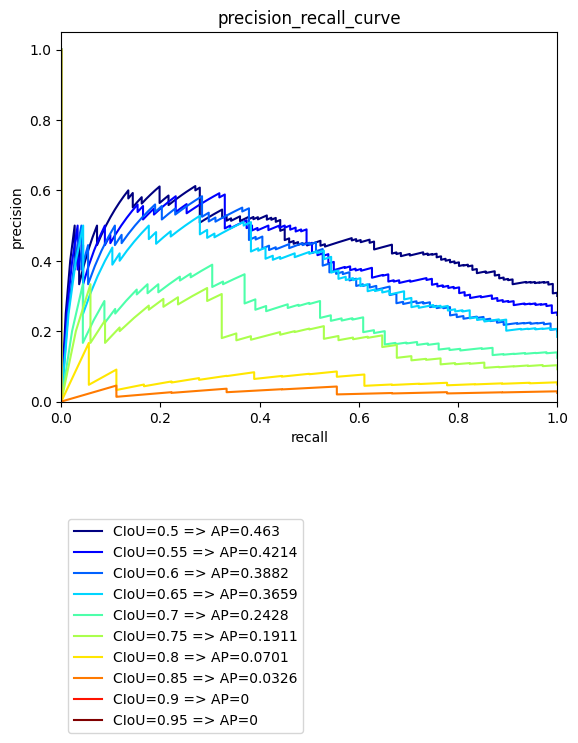

In [17]:
iou_thresholds = np.arange(0.5, 1.0, 0.05)      

precisions, recalls, f1s = [], [], []
y_trues  = []
y_scores = []
for iou_threshold in iou_thresholds:
    y_true   = []                # 0:無壺腹乳頭 1:有壺腹乳頭
    y_score  = []                # confidence分數
    for r in range(row):         # row: 列數
        test_img_name = result_table.iloc[r:r+1]['test_name'][r]
        true_bbox     = result_table.iloc[r:r+1]['true_bbox'][r]
        pred_bbox     = result_table.iloc[r:r+1]['pred_bbox'][r]
        score         = result_table.iloc[r:r+1]['score'][r]

        if true_bbox != 'NO' and pred_bbox != 'NO':
            ciou = get_iou(true_bbox, pred_bbox)           # 找出真實box和預測box的iou
            # ciou = calculate_ciou(true_bbox, pred_bbox)                     # 找出真實box和預測box的ciou
            
            if ciou >= iou_threshold:   # 如果>=iou，才是有預測到，TP會增加
                y_true.append(1)
                y_score.append(score)
            else:
                y_true.append(0)
                y_score.append(score)
        # elif true_bbox != 'NO' and pred_bbox == 'NO':   # FN
        #     y_true.append(1)
        #     y_score.append(0)
        elif true_bbox == 'NO' and pred_bbox != 'NO':
            y_true.append(0)
            y_score.append(score)

    y_trues.append(y_true)
    y_scores.append(y_score)

plt_precision_recall_curve_2(iou_thresholds, y_trues, y_scores)     # 畫PR curve